In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('Week_3/week_3_final_dataset.csv')

Removing the Live and Time columns as we no longer want to use it

In [4]:
df = df.drop(columns=['Live', 'Time'])

Slightly altered the week 3 eda notebook to re-catagorize subgenres that had fewer than 15 instances, now only 42 total subgenres exist

In [5]:
subgenre_counts = df['Subgenre'].value_counts()
subgenre_counts

Subgenre
hip hop              272
indie rock           207
indie pop            203
pop 80s              168
alternative rock     163
rock 70s             148
rock 80s             144
country              130
pop                  124
rock                 119
electronic            88
rnb                   86
pop rock              75
folk                  67
country pop           63
indie                 62
alternative           59
rock 60s              54
alternative rnb       51
dance                 49
indie folk            48
dance pop             46
pop 70s               46
pop dance             46
folk rock             45
soul                  45
rock alternative      43
hip hop rnb           36
soul 70s              35
rock 90s              31
electronic pop        28
pop 90s               27
electronic dance      27
soul rnb              23
pop 60s               22
indie alternative     19
pop synthpop          19
hip hop 90s           19
pop rnb               19
soul 80s        

Preparing the data for tokenization by cleaning the lyrics, also removing stop words and lemanizing the lyrics

In [6]:
# Load spaCy model and stopwords
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = set(stopwords.words("english"))

def clean_lyrics(text):
    if pd.isnull(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove [annotations like chorus/verse]
    text = re.sub(r"\[.*?\]", "", text)

    # Remove all punctuation (including apostrophes) - modification from week 4 to 5.
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize with spaCy
    doc = nlp(text)

    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.lemma_ not in stop_words]

    return " ".join(tokens)


In [7]:
df['Clean_Lyrics'] = df['Lyrics'].apply(clean_lyrics)

In [8]:
df = df.drop(columns='Lyrics')

In [9]:
df

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Camelot,Genre,Subgenre,Clean_Lyrics
0,I'm So Excited,The Pointer Sisters,65,92,69,86,10,69,-6,4B,pop,pop 80s,tonight night go make happen tonight well put ...
1,Cheri Cheri Lady,Modern Talking,82,114,68,62,46,85,-14,6B,pop,pop 80s,oh explain every time oh feel real take heart ...
2,Give It Up,KC & The Sunshine Band,58,126,84,65,8,84,-12,5B,pop,pop,everybody want everybody want love like make m...
3,It's Raining Men - Single Version,The Weather Girls,50,136,66,93,46,46,-6,4A,pop,pop,hi hi weather girl uh huh get news well listen...
4,Take on Me,a-ha,89,84,57,90,2,88,-8,11A,pop,pop 80s,talk away know say ill say anyway today anothe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,Play That Funky Music,Wild Cherry,76,109,81,67,4,93,-12,11B,soul,soul disco,ahey huh yeah hey heyah boogie singer playing ...
3017,Rock with You - Single Version,Michael Jackson,82,114,81,54,18,85,-13,3B,pop,pop 80s,girl close eye let rhythm get try fight nothin...
3018,You Sexy Thing,Hot Chocolate,75,106,79,73,52,96,-5,7B,soul,soul disco,believe miracle sexy thing sexy thing believe ...
3019,Get It On,T. Rex,72,127,73,88,18,91,-7,10A,rock,rock 70s,well dirty sweet clad black look back love dir...


Add interaction feature 'Power' before data splitting. Power = loud x energy. 
Loud and energy have a high correlation coefficient:0.73, making it a good candidate for an interaction term. 

In [14]:
# Add interaction term 'Power': Power = Loud * Energy
df['Power'] = df['Loud'] * df['Energy']

Visualize the numerical category distributions.

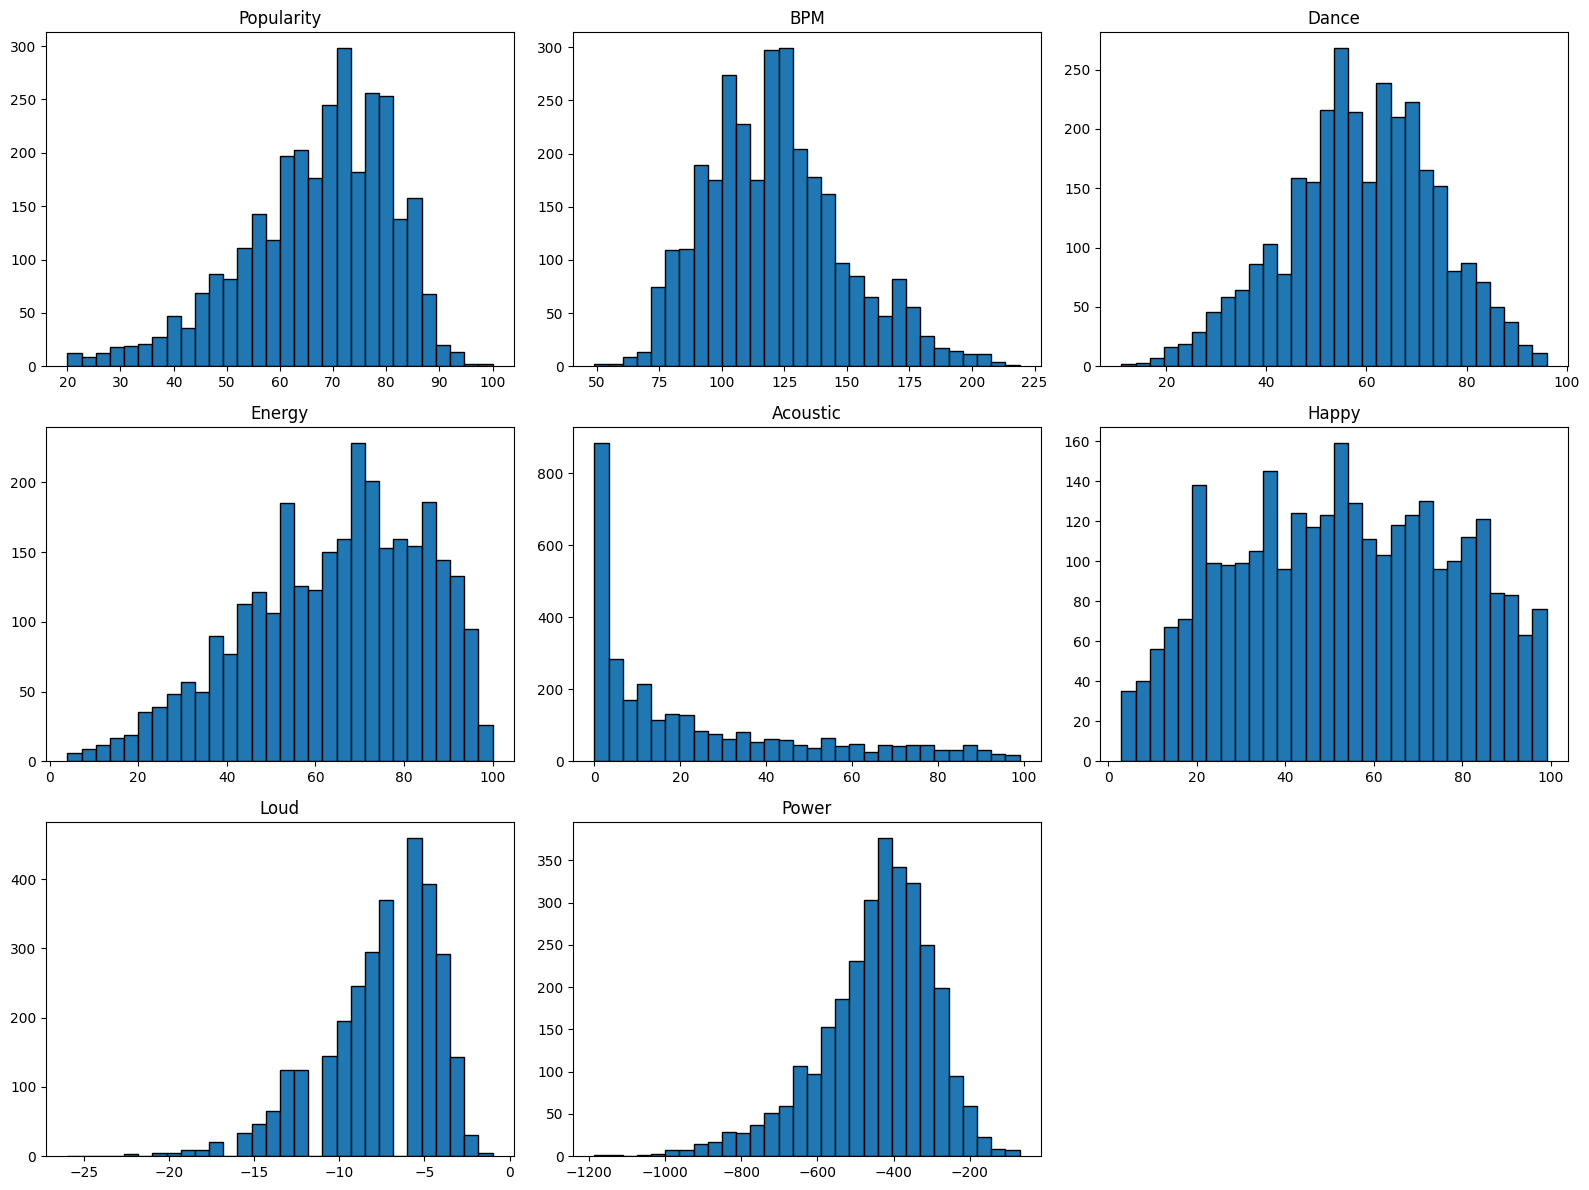

In [15]:
# List of numeric columns
numeric_cols = ['Popularity', 'BPM', 'Dance', 'Energy', 'Acoustic', 'Happy', 'Loud', 'Power']

# Set up subplots
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[col], bins=30, edgecolor='k')
    plt.title(col)

plt.tight_layout()
plt.show()


Transform acoustic with a log transformation.

In [12]:
# Apply square root to Acoustic
df['sqrt_Acoustic'] = np.sqrt(df['Acoustic'])

# Apply square root to BPM
df['sqrt_BPM'] = np.sqrt(df['BPM'])

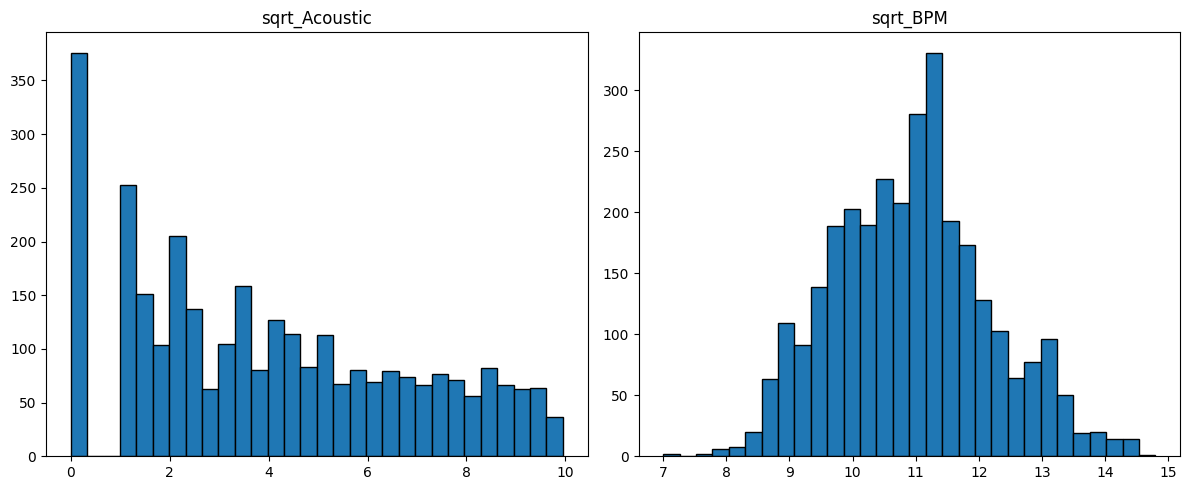

In [13]:
# List of transformed features
transformed_cols = ['sqrt_Acoustic', 'sqrt_BPM']

# Set up subplots
plt.figure(figsize=(12, 5))

for i, col in enumerate(transformed_cols, 1):
    plt.subplot(1, 2, i)
    plt.hist(df[col], bins=30, edgecolor='k')
    plt.title(col)

plt.tight_layout()
plt.show()


Split the data before feature normalization to prevent data leakage. 

In [16]:
# Split data
df_train, temp_df = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(temp_df, test_size=0.5, random_state=42)

Normalizing the numeric features on a 0 to 1 scale. Perform the normalization on the training data first. Then use the scalers from the training transformation to normalize the test and validation sets. This will prevent data leakage and prevent the model from over performing. 

In [17]:
# Select only numeric columns
numeric_cols = df_train.select_dtypes(include='number').columns

# Create a scaler and fit-transform the numeric columns
scaler = MinMaxScaler()
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])

In [18]:
# Calculate the scaled means
scaled_means = df_train[numeric_cols].mean()

# Create a scaler summary DataFrame
scaler_summary = pd.DataFrame({
    'feature': numeric_cols,
    'original_min': scaler.data_min_,
    'original_max': scaler.data_max_,
    'scaler': scaler.scale_,          # 1 / (max - min)
    'scaled_mean': scaled_means.values
})

# Display
scaler_summary.set_index('feature', inplace=True)
display(scaler_summary)

,original_min,original_max,scaler,scaled_mean
feature,,,,
Popularity,20.0,100.000000,0.012500,0.588476
BPM,49.0,219.000000,0.005882,0.424823
Dance,11.0,96.000000,0.011765,0.565006
Energy,5.0,100.000000,0.010526,0.624075
Acoustic,0.0,99.000000,0.010101,0.235639
Happy,3.0,98.000000,0.010526,0.525564
Loud,-26.0,-1.000000,0.040000,0.731693
Power,-1036.0,-70.000000,0.001035,0.611998
sqrt_Acoustic,0.0,9.949874,0.100504,0.392503


In [19]:
# Apply the same transformation to validation and test sets
df_val[numeric_cols] = scaler.transform(df_val[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [21]:
# Save to CSV
df_train.to_csv("Week_4/week_4_train_set.csv", index=False)
df_test.to_csv("Week_4/week_4_test_set.csv", index=False)
df_val.to_csv("Week_4/week_4_validation_set.csv", index=False)


In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import nltk
from nltk.tokenize import word_tokenize
!pip install gensim

from gensim.models.fasttext import load_facebook_vectors
from gensim.models import KeyedVectors

In [23]:
df_train.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Camelot,Genre,Subgenre,Clean_Lyrics,Power,sqrt_Acoustic,sqrt_BPM
2739,Stretch You Out (feat. A Boogie wit da Hoodie),"Summer Walker,A Boogie Wit da Hoodie",0.50,0.317647,0.623529,0.494737,0.252525,0.231579,0.76,12A,soul,soul rnb,get london da track niggas insecure claim enou...,0.695652,0.502519,0.403774
440,On Melancholy Hill,Gorillaz,0.80,0.417647,0.682353,0.726316,0.000000,0.578947,0.80,10B,electronic,electronic,melancholy hill good side consumerism like muc...,0.612836,0.000000,0.507069
508,WHO CARES?,Rex Orange County,0.35,0.217647,0.835294,0.242105,0.595960,0.589474,0.80,4B,indie,indie pop,mmmm mmmm mmmm mmmm first time try free doubt ...,0.898551,0.771984,0.291540
76,Solid,Ashford & Simpson,0.45,0.305882,0.823529,0.442105,0.272727,0.978947,0.56,8B,soul,soul 80s,love sake mistake oh forgave soon learn trust ...,0.488613,0.522233,0.391077
1947,BREAK MY SOUL,Beyoncé,0.55,0.388235,0.682353,0.884211,0.060606,0.863158,0.84,12A,dance,dance pop,bout explode take load bend bust open ya make ...,0.611801,0.246183,0.477494


Camelot in practice is a circular scale. We could one hot encode 0-23, but 23 and 0 are just as close on the Camelot scale as 0 and 1. Instead we will code Camelot to have sin and cos coordinates (mapping on the unit circle) to better model songs in latent space.

In [24]:
#Circular encoding for Camelot

def camelot_to_position(code):
    number = int(code[:-1])   # extract number (1-12)
    mode = code[-1]           # extract mode (A or B)
    mode_offset = 0 if mode == 'A' else 12        # Start at 0 if mode is A, if not start at 13
    return (number - 1) + mode_offset 

def add_sin_cos(df):
    df['camelot_pos'] = df['Camelot'].map(camelot_to_position) #map camelot positions to 0-23
    df['camelot_sin'] = np.sin(2 * np.pi * df['camelot_pos'] / 24)        #compute sine transformation 
    df['camelot_cos'] = np.cos(2 * np.pi * df['camelot_pos'] / 24)        #compute cosine transformation
    df.drop(['Camelot', 'camelot_pos'], axis=1, inplace=True)             #Drop camelot and intermediate position column.
    return df

#Apply transformation to train, test, val sets.
df_train = add_sin_cos(df_train)
df_val = add_sin_cos(df_val)
df_test = add_sin_cos(df_test)

Create a list of variables that we want to encode

In [25]:
one_hot_cols = ['Genre', 'Subgenre']

In [26]:
# One-hot encoder (for Genre and Subgenre)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(df_train[one_hot_cols])

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [27]:
# Helper function to transform and reattach
def encode_and_concat(df, encoder, categorical_cols):
    encoded = encoder.transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    return pd.concat([df.drop(one_hot_cols, axis=1), encoded_df], axis=1)

In [28]:
# Apply to each split
df_train_encoded = encode_and_concat(df_train, encoder, one_hot_cols)
df_val_encoded = encode_and_concat(df_val, encoder, one_hot_cols)
df_test_encoded = encode_and_concat(df_test, encoder, one_hot_cols)

In [29]:
df_val_encoded.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Clean_Lyrics,...,Subgenre_rock 70s,Subgenre_rock 80s,Subgenre_rock 90s,Subgenre_rock alternative,Subgenre_soul,Subgenre_soul 60s,Subgenre_soul 70s,Subgenre_soul 80s,Subgenre_soul disco,Subgenre_soul rnb
1591,Rebel Yell,Billy Idol,0.7375,0.688235,0.494118,0.852632,0.000000,0.484211,0.84,last night little dancer acame dancin door las...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,Lonely People,America,0.5750,0.176471,0.529412,0.442105,0.262626,0.557895,0.68,lonely people thinkin life pass give drink sil...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,What A Feeling,Irene Cara,0.6375,0.429412,0.494118,0.715789,0.383838,0.600000,0.76,first nothing slow glow dream fear seem hide d...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,Bird on the Wire,Leonard Cohen,0.4000,0.464706,0.341176,0.063158,0.848485,0.168421,0.40,like bird wire like drunk midnight choir try w...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2937,I'll Say Forever My Love,Jimmy Ruffin,0.1750,0.323529,0.517647,0.600000,0.010101,0.663158,0.76,forever forever forever love ill say forever l...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
list(df_val_encoded.columns)

['Song',
 'Artist',
 'Popularity',
 'BPM',
 'Dance',
 'Energy',
 'Acoustic',
 'Happy',
 'Loud',
 'Clean_Lyrics',
 'Power',
 'sqrt_Acoustic',
 'sqrt_BPM',
 'camelot_sin',
 'camelot_cos',
 'Genre_alternative',
 'Genre_country',
 'Genre_dance',
 'Genre_electronic',
 'Genre_folk',
 'Genre_hip hop',
 'Genre_indie',
 'Genre_pop',
 'Genre_rnb',
 'Genre_rock',
 'Genre_soul',
 'Subgenre_alternative',
 'Subgenre_alternative rnb',
 'Subgenre_alternative rock',
 'Subgenre_country',
 'Subgenre_country pop',
 'Subgenre_dance',
 'Subgenre_dance electronic',
 'Subgenre_dance pop',
 'Subgenre_electronic',
 'Subgenre_electronic dance',
 'Subgenre_electronic pop',
 'Subgenre_folk',
 'Subgenre_folk rock',
 'Subgenre_hip hop',
 'Subgenre_hip hop 90s',
 'Subgenre_hip hop rnb',
 'Subgenre_indie',
 'Subgenre_indie alternative',
 'Subgenre_indie folk',
 'Subgenre_indie pop',
 'Subgenre_indie rock',
 'Subgenre_pop',
 'Subgenre_pop 60s',
 'Subgenre_pop 70s',
 'Subgenre_pop 80s',
 'Subgenre_pop 90s',
 'Subgenre_p

In [31]:
df_train_encoded.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Clean_Lyrics,...,Subgenre_rock 70s,Subgenre_rock 80s,Subgenre_rock 90s,Subgenre_rock alternative,Subgenre_soul,Subgenre_soul 60s,Subgenre_soul 70s,Subgenre_soul 80s,Subgenre_soul disco,Subgenre_soul rnb
2739,Stretch You Out (feat. A Boogie wit da Hoodie),"Summer Walker,A Boogie Wit da Hoodie",0.50,0.317647,0.623529,0.494737,0.252525,0.231579,0.76,get london da track niggas insecure claim enou...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
440,On Melancholy Hill,Gorillaz,0.80,0.417647,0.682353,0.726316,0.000000,0.578947,0.80,melancholy hill good side consumerism like muc...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508,WHO CARES?,Rex Orange County,0.35,0.217647,0.835294,0.242105,0.595960,0.589474,0.80,mmmm mmmm mmmm mmmm first time try free doubt ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,Solid,Ashford & Simpson,0.45,0.305882,0.823529,0.442105,0.272727,0.978947,0.56,love sake mistake oh forgave soon learn trust ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1947,BREAK MY SOUL,Beyoncé,0.55,0.388235,0.682353,0.884211,0.060606,0.863158,0.84,bout explode take load bend bust open ya make ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tokenize the Lyrics

In [32]:
def simple_tokenize(text):
  return text.split()

In [33]:
# Apply to all three DataFrames
for df in [df_train_encoded, df_val_encoded, df_test_encoded]:
    df['Tokens'] = df['Clean_Lyrics'].apply(simple_tokenize)

In [34]:
df_train_encoded.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Clean_Lyrics,...,Subgenre_rock 80s,Subgenre_rock 90s,Subgenre_rock alternative,Subgenre_soul,Subgenre_soul 60s,Subgenre_soul 70s,Subgenre_soul 80s,Subgenre_soul disco,Subgenre_soul rnb,Tokens
2739,Stretch You Out (feat. A Boogie wit da Hoodie),"Summer Walker,A Boogie Wit da Hoodie",0.50,0.317647,0.623529,0.494737,0.252525,0.231579,0.76,get london da track niggas insecure claim enou...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[get, london, da, track, niggas, insecure, cla..."
440,On Melancholy Hill,Gorillaz,0.80,0.417647,0.682353,0.726316,0.000000,0.578947,0.80,melancholy hill good side consumerism like muc...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[melancholy, hill, good, side, consumerism, li..."
508,WHO CARES?,Rex Orange County,0.35,0.217647,0.835294,0.242105,0.595960,0.589474,0.80,mmmm mmmm mmmm mmmm first time try free doubt ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[mmmm, mmmm, mmmm, mmmm, first, time, try, fre..."
76,Solid,Ashford & Simpson,0.45,0.305882,0.823529,0.442105,0.272727,0.978947,0.56,love sake mistake oh forgave soon learn trust ...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[love, sake, mistake, oh, forgave, soon, learn..."
1947,BREAK MY SOUL,Beyoncé,0.55,0.388235,0.682353,0.884211,0.060606,0.863158,0.84,bout explode take load bend bust open ya make ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[bout, explode, take, load, bend, bust, open, ..."


In [37]:
print(df_train_encoded.columns)

Index(['Song', 'Artist', 'Popularity', 'BPM', 'Dance', 'Energy', 'Acoustic',
       'Happy', 'Loud', 'Clean_Lyrics', 'Power', 'sqrt_Acoustic', 'sqrt_BPM',
       'camelot_sin', 'camelot_cos', 'Genre_alternative', 'Genre_country',
       'Genre_dance', 'Genre_electronic', 'Genre_folk', 'Genre_hip hop',
       'Genre_indie', 'Genre_pop', 'Genre_rnb', 'Genre_rock', 'Genre_soul',
       'Subgenre_alternative', 'Subgenre_alternative rnb',
       'Subgenre_alternative rock', 'Subgenre_country', 'Subgenre_country pop',
       'Subgenre_dance', 'Subgenre_dance electronic', 'Subgenre_dance pop',
       'Subgenre_electronic', 'Subgenre_electronic dance',
       'Subgenre_electronic pop', 'Subgenre_folk', 'Subgenre_folk rock',
       'Subgenre_hip hop', 'Subgenre_hip hop 90s', 'Subgenre_hip hop rnb',
       'Subgenre_indie', 'Subgenre_indie alternative', 'Subgenre_indie folk',
       'Subgenre_indie pop', 'Subgenre_indie rock', 'Subgenre_pop',
       'Subgenre_pop 60s', 'Subgenre_pop 70s', 'Subge

In [38]:
df_train_encoded[['camelot_sin', 'camelot_cos']].head()

,camelot_sin,camelot_cos
2739,0.258819,-0.965926
440,-0.707107,0.707107
508,-0.707107,-0.707107
76,-0.965926,0.258819
1947,0.258819,-0.965926


In [39]:
num_songs = len(df_train_encoded)

print(num_songs)

2114


In [42]:
#Change path to your own when running so no errors occur - the file can be found in the data folder for now
glove_path = r'C:\Users\Ryan\Downloads\crawl-300d-2M-subword.vec\crawl-300d-2M-subword.vec'

fasttext_model = KeyedVectors.load_word2vec_format(glove_path, binary=False)

In [43]:
fasttext_model['love']

array([ 2.830e-02, -6.750e-02,  1.439e-01,  4.900e-02, -5.410e-02,
       -6.450e-02,  1.784e-01,  1.900e-02,  1.581e-01, -5.000e-04,
       -6.250e-02, -8.160e-02,  5.070e-02,  1.950e-02, -2.430e-02,
        9.000e-03, -1.690e-02,  1.800e-02, -2.660e-02,  7.450e-02,
       -4.700e-03,  2.460e-02, -7.040e-02, -2.320e-02,  1.196e-01,
        2.390e-02,  3.600e-02, -1.230e-02,  8.310e-02,  1.073e-01,
       -4.320e-02, -1.167e-01, -2.840e-02, -1.630e-02, -1.980e-02,
        4.480e-02,  8.810e-02,  1.280e-02, -9.140e-02,  3.460e-02,
       -1.268e-01, -1.388e-01, -1.340e-02,  8.290e-02, -2.490e-02,
        1.423e-01, -7.780e-02, -3.240e-02, -1.005e-01,  1.460e-02,
        3.700e-03, -1.240e-02,  1.042e-01,  9.220e-02, -8.640e-02,
        8.580e-02, -1.330e-02, -5.090e-02, -1.786e-01,  5.330e-02,
        5.830e-02,  1.780e-02, -6.600e-03,  1.740e-02, -1.740e-02,
        4.500e-02, -1.700e-02,  2.280e-02, -6.700e-03, -4.960e-02,
        2.500e-02, -2.030e-02, -2.480e-02, -7.900e-02,  3.830e

In [44]:
def get_fasttext_embedding(tokens, model, dim=300):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

In [45]:
#Creating new column 'Embeddings' for the final lyric conversions

for df in [df_train_encoded, df_val_encoded, df_test_encoded]:
    df['Embeddings'] = df['Tokens'].apply(lambda tokens: get_fasttext_embedding(tokens, fasttext_model))

In [46]:
df_train_encoded.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Clean_Lyrics,...,Subgenre_rock 90s,Subgenre_rock alternative,Subgenre_soul,Subgenre_soul 60s,Subgenre_soul 70s,Subgenre_soul 80s,Subgenre_soul disco,Subgenre_soul rnb,Tokens,Embeddings
2739,Stretch You Out (feat. A Boogie wit da Hoodie),"Summer Walker,A Boogie Wit da Hoodie",0.50,0.317647,0.623529,0.494737,0.252525,0.231579,0.76,get london da track niggas insecure claim enou...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[get, london, da, track, niggas, insecure, cla...","[-0.018264085, -0.04250281, 0.12470213, -0.002..."
440,On Melancholy Hill,Gorillaz,0.80,0.417647,0.682353,0.726316,0.000000,0.578947,0.80,melancholy hill good side consumerism like muc...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[melancholy, hill, good, side, consumerism, li...","[-0.0044901404, -0.042698584, 0.11501128, 0.01..."
508,WHO CARES?,Rex Orange County,0.35,0.217647,0.835294,0.242105,0.595960,0.589474,0.80,mmmm mmmm mmmm mmmm first time try free doubt ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[mmmm, mmmm, mmmm, mmmm, first, time, try, fre...","[-0.0018745449, -0.036825456, 0.14365092, 0.00..."
76,Solid,Ashford & Simpson,0.45,0.305882,0.823529,0.442105,0.272727,0.978947,0.56,love sake mistake oh forgave soon learn trust ...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[love, sake, mistake, oh, forgave, soon, learn...","[-0.013666291, -0.011470232, 0.11901681, 0.021..."
1947,BREAK MY SOUL,Beyoncé,0.55,0.388235,0.682353,0.884211,0.060606,0.863158,0.84,bout explode take load bend bust open ya make ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[bout, explode, take, load, bend, bust, open, ...","[-0.017157331, -0.050722662, 0.11092369, 0.000..."


In [ ]:
# Save the encoded dataframes
df_train_encoded.to_csv("Week_5/week_5_train_set.csv", index=False)
df_val_encoded.to_csv("Week_5/week_5_validation_set.csv", index=False)
df_test_encoded.to_csv("Week_5/week_5_test_set.csv", index=False)